# Outline 
1.	Problem description
2.	Load library, get data, have an overview
3.	Data preprocessing: data clean, adding derived features
4.	Data visualization
    1.	Plot histograms of various relevant quantities
    2.	Group features by week, by day of the week, hour of the day
    3.	Geometrical features, airport trips vs. non airport trips
5.	Correlation overview
6.	Modeling
    2.	Train, cross-validation data set splitting
    3.	Linear regression
    4.	KNeighbors
    5.	Decision Tree
    6.	RandomForest 
7.	Summary


## 1. Problem description
Kaggle NYC taxi trip duration practice
https://www.kaggle.com/c/nyc-taxi-trip-duration

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

#### File descriptions
**train.csv** - the training set (contains 1458644 trip records)<br>
**test.csv** - the testing set (contains 625134 trip records)<br>

#### Data fields
**id** - a unique identifier for each trip<br>
**vendor_id** - a code indicating the provider associated with the trip record<br>
**pickup_datetime** - date and time when the meter was engaged<br>
**dropoff_datetime** - date and time when the meter was disengaged<br>
**passenger_count** - the number of passengers in the vehicle (driver entered value)<br>
**pickup_longitude** - the longitude where the meter was engaged<br>
**pickup_latitude** - the latitude where the meter was engaged<br>
**dropoff_longitude** - the longitude where the meter was disengaged<br>
**dropoff_latitude** - the latitude where the meter was disengaged<br>
**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip<br>
**trip_duration** - duration of the trip in seconds<br>
Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.<br>

## 2.	Load library, get data, have an overview

In [1]:
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')

# general libraries
import pandas as pd
import numpy as np
import re
import sys
import os
import sklearn
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print('Python Verson:', sys.version)
print('Numpy Version:', np.__version__)
print('Pandas Verion:', pd.__version__)
print('Scikit-learn Version:', sklearn.__version__)

Python Verson: 3.6.1 (v3.6.1:69c0db5050, Mar 21 2017, 01:21:04) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Numpy Version: 1.14.0
Pandas Verion: 0.22.0
Scikit-learn Version: 0.19.1


Get data and have an overview.

In [3]:
# get train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print('The trip data has %d rows and %d columns.' % (train_data.shape[0], train_data.shape[1]))

The trip data has 1458644 rows and 11 columns.


In [5]:
# have an overview of what the data look like
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
## other functions that can have an overview of the total data
train_data.info()
#train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


This data set has 1458644 rows and 11 columns.

## 3.	Data preprocessing: data clean, adding derived features
Degrees of latitude are parallel so the distance between each degree remains almost constant but since degrees of longitude are farthest apart at the equator and converge at the poles, their distance varies greatly.

Each degree of latitude is approximately 69 miles (111 kilometers) apart. The range varies (due to the earth's slightly ellipsoid shape) from 68.703 miles (110.567 km) at the equator to 69.407 (111.699 km) at the poles. This is convenient because each minute (1/60th of a degree) is approximately one [nautical] mile.

A degree of longitude is widest at the equator at 69.172 miles (111.321) and gradually shrinks to zero at the poles. At 40° north or south the distance between a degree of longitude is 53 miles (85 km)

so at 40° north: 1 mile latitude ~1/69=0.015°; 1 mile longitude ~1/53=0.01887°

**Distance**
This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points (ignoring any hills they fly over, of course!).

Haversine
formula:	a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
c = 2 ⋅ atan2( √a, √(1−a) )
d = R ⋅ c
where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!

In [8]:
#calculate distance
import math
def cal_distance(lat1,long1,lat2,long2):
    lat1=math.radians(lat1)
    lat2=math.radians(lat2)
    long1=math.radians(long1)
    long2=math.radians(long2)
    R=3959 # miles
    a=math.pow(math.sin((lat1-lat2)/2),2)
    +math.cos(lat1)*math.cos(lat2)*math.pow(math.sin((long1-long2)/2),2)
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R*c

In [9]:
type(train_data['trip_duration'])

pandas.core.series.Series

In [10]:
# derive some variables
train_data['pickup_datetime']=pd.to_datetime(train_data['pickup_datetime'])
train_data['dropoff_datetime']=pd.to_datetime(train_data['dropoff_datetime'])
train_data.loc[:,'Pickup_hour']=train_data['pickup_datetime'].dt.hour
train_data.loc[:,'Dropoff_hour']=train_data['dropoff_datetime'].dt.hour
train_data.loc[:,'Trip_distance']=np.vectorize(cal_distance)(train_data['pickup_latitude'],
train_data['pickup_longitude'],train_data['dropoff_latitude'],train_data['dropoff_longitude'])
train_data.loc[:,'Avg_speed']=train_data['Trip_distance']/train_data['trip_duration']*3600
train_data.loc[:,'Pickup_week']=train_data['pickup_datetime'].dt.week
train_data.loc[:,'Pickup_weekday']=train_data['pickup_datetime'].dt.weekday
train_data.loc[:,'TripID']=range(1,train_data.shape[0]+1)
train_data.loc[:,'Trip_time']=(train_data['dropoff_datetime']
                               -train_data['pickup_datetime']).dt.total_seconds()/60


In [11]:
# data cleaning, choose the features that might be useful for modeling, Ehail_fee are mostly 0, so I do not choose it.
# Here is a bruteforce way to simply drop the NA and inf entries to clean data.
u = np.median(train_data['trip_duration'])
s=np.std(train_data['trip_duration'])
num=2
clean_data = train_data.drop(train_data[train_data.trip_duration > u+num*s].index)
clean_data = clean_data.drop(train_data[train_data.trip_duration < u-num*s].index)
clean_data=clean_data.replace([np.inf, -np.inf], np.nan).dropna()

u = np.median(clean_data['Avg_speed'])
s=np.std(clean_data['Avg_speed'])
num=5
clean_data = clean_data.drop(clean_data[clean_data.Avg_speed > u+num*s].index)
clean_data = clean_data.drop(clean_data[clean_data.Avg_speed < u-num*s].index)
clean_data=clean_data.replace([np.inf, -np.inf], np.nan).dropna()
##### scale data, since all the data are in the range of 0-100, data scale is not necessary.
#test_scaled = scale.fit_transform(test[['Passenger_count','Trip_distance']].as_matrix()) 
#test_scaled = preprocessing.scale(test[['Passenger_count','Trip_distance',
#'Trip_time']].as_matrix())
#test1=pd.DataFrame(test_scaled)
clean_data.shape

(1456357, 19)

In [12]:
# remove outliers
def reject_outliers(data,num):
    u = np.median(data)
    s = np.std(data)
    filtered = [e for e in data if (u - num * s < e < u + num * s)]
    return filtered
clean_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'Pickup_hour', 'Dropoff_hour', 'Trip_distance',
       'Avg_speed', 'Pickup_week', 'Pickup_weekday', 'TripID', 'Trip_time'],
      dtype='object')

## 4. Data visualization
### 4.1. Plot histograms of various relevant quantities

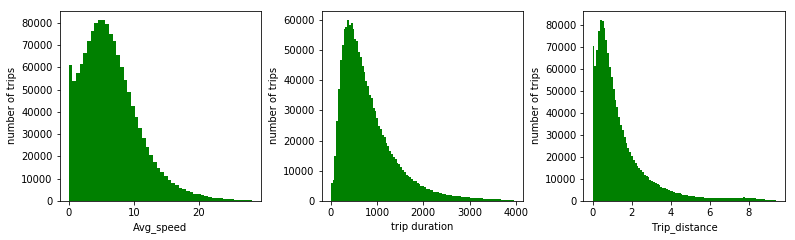

max Trip_duration is 11099. Median is 662.0. Mean is 836.91241. Standard deviation is 658.68359.


In [13]:
# plot histogram of the avg_speed, Trip_duration, Trip_distance
fig = plt.figure(figsize=(13,3.5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = fig.add_subplot(1, 3, 1)
plt.hist(reject_outliers(clean_data['Avg_speed'],5), bins=50,normed=False, alpha = 1, 
         color = 'g',label='total passenger count PDF')
plt.xlabel('Avg_speed')
plt.ylabel('number of trips')

ax = fig.add_subplot(1, 3, 2)
plt.hist(reject_outliers(clean_data['trip_duration'],5), bins=100,normed=False, alpha = 1, 
         color = 'g')
plt.xlabel('trip duration')
plt.ylabel('number of trips')

ax = fig.add_subplot(1, 3, 3)
plt.hist(reject_outliers(clean_data['Trip_distance'],5), bins=100,normed=False, alpha = 1,
         color = 'g')
plt.xlabel('Trip_distance')
plt.ylabel('number of trips')
plt.show()
print('max Trip_duration is '+str(max(clean_data['trip_duration']))+'. Median is '
      +str(np.median(clean_data['trip_duration']))+'. Mean is '
      + str(round(np.mean(clean_data['trip_duration']),5))+
      '. Standard deviation is '+str(round(np.std(clean_data['trip_duration']),5))+'.')

In [14]:
#sorted(clean_data.Pickup_week.unique())

### 4.2.	Group features by week, by day of the week, hour of the day

[825.9050882447501, 904.909123862689, 796.9383564671558, 838.3730256764992, 806.4192191758569, 892.7670600402607, 876.8335122926541, 927.8746828933836, 861.5576904656999, 826.9086295295504, 908.8867730940457, 788.426206244087, 876.061908664233, 863.4959477036988, 890.4324442501094, 806.4801710863986, 822.391170932422, 885.3154376088004, 781.3328301758789, 736.1121734547918, 875.0464861761487, 716.4166374693428, 867.2428862301647, 797.7559956364856, 782.1523867263422, 765.0675592462921, 820.1954025013212]


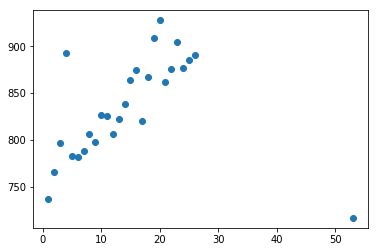

In [15]:
# The averaga speed is derived before as: (mph)
# total_data.loc[:,'Avg_speed']=total_data['Trip_distance']/total_data['Trip_time']*60
Trip_duration,mean_by_week,week_no,week_trips=[],[],[],[]
for week in clean_data.Pickup_week.unique():
    Trip_duration.append(clean_data.loc[clean_data['Pickup_week']==week]['trip_duration'])
    mean_by_week.append(clean_data.loc[clean_data['Pickup_week']==week]
                        ['trip_duration'].mean())
    week_no.append(week)
    week_trips.append(len(Trip_duration))
#clean_data.info()
print(mean_by_week)
plt.scatter(week_no,mean_by_week)
plt.plot()
plt.show()

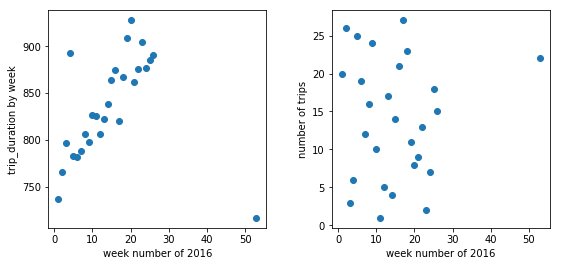

In [16]:
# plot avg_speed and total number of trips for each week
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = fig.add_subplot(1, 2, 1)
plt.scatter(week_no,mean_by_week)
plt.ylabel('trip_duration by week')
plt.xlabel('week number of 2016')

ax = fig.add_subplot(1, 2, 2)
plt.scatter(week_no,week_trips)
plt.ylabel('number of trips')
plt.xlabel('week number of 2016')
plt.show()

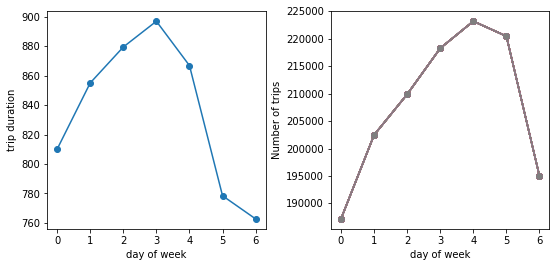

In [17]:
# plot avg_speed and total trip by day of the week
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = fig.add_subplot(1, 2, 1)
avg_speed_by_weekday=clean_data.groupby(['Pickup_weekday']).mean()
plt.plot(avg_speed_by_weekday['trip_duration'],'o-') 
plt.ylabel('trip duration')
plt.xlabel('day of week')
#The day of the week with Monday=0, Sunday=6

ax = fig.add_subplot(1, 2, 2)
plt.plot(clean_data.groupby(['Pickup_weekday']).count(),'o-') 
plt.ylabel('Number of trips')
plt.xlabel('day of week')
plt.show()

Avg speed is lowest in the middle of the week, and high on Monday and Sunday. That last week, i.e. the 5th week has Mon, Tue, and Wed only, results in a larger avg speed.

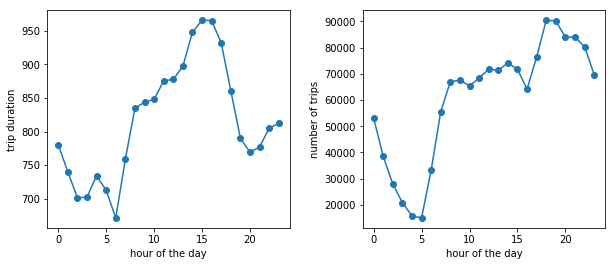

In [18]:
# plot avg_speed and total trips by hour of the day
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
data_by_PickHour=clean_data.groupby(['Pickup_hour'])
plt.plot(data_by_PickHour['trip_duration'].mean(),'o-')
plt.ylabel('trip duration')
plt.xlabel('hour of the day')

ax = fig.add_subplot(1, 2, 2)
plt.plot(data_by_PickHour['trip_duration'].count(),'o-')
plt.ylabel('number of trips')
plt.xlabel('hour of the day')
plt.show()

In [19]:
np.corrcoef(data_by_PickHour['trip_duration'].mean(), 
            data_by_PickHour['trip_duration'].count())[0, 1]

0.6367295619758084

From the plot and the correlation coefficient, it shows that the avg_speed has peak at 5 am where the total number of trips is minimum. It makes sense since less traffice results in increased avg_speed. There might also be other factors like pedestrian not considered here.

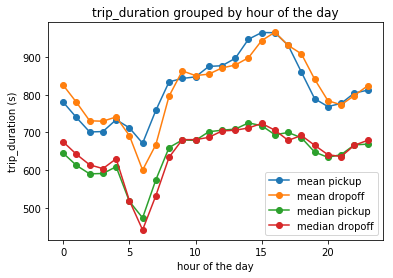

In [20]:
mean_by_PickHour=clean_data.groupby(['Pickup_hour']).mean()
mean_by_DropHour=clean_data.groupby(['Dropoff_hour']).mean()
median_by_PickHour=clean_data.groupby(['Pickup_hour']).median()
median_by_DropHour=clean_data.groupby(['Dropoff_hour']).median()
plt.plot(mean_by_PickHour['trip_duration'],'o-', label='mean pickup')
plt.plot(mean_by_DropHour['trip_duration'],'o-', label='mean dropoff')
plt.plot(median_by_PickHour['trip_duration'],'o-', label='median pickup')
plt.plot(median_by_DropHour['trip_duration'],'o-', label='median dropoff')
plt.ylabel('trip_duration (s)')
plt.xlabel('hour of the day')
plt.legend(loc=0)
plt.title('trip_duration grouped by hour of the day')
plt.show()

The trip duration grouped by pickup or drop hour does not make much difference. The mean duration is larger than the median since the duration is skewed to the right as we see before. The trip duration has a dip at 6 am. 

### 4.3. Geometrical features, airport trips vs. non airport trips
#### NYC area airports
From Wikipedia: https://en.wikipedia.org/wiki/Aviation_in_the_New_York_metropolitan_area <br>
There are 3 major airports:

John F. Kennedy International Airport: 40°38′23″N 073°46′44″W (40.639722, -73.778889)

Newark Liberty International Airport: 40°41′33″N 074°10′07″W (40.6925, -74.168611)

LaGuardia Airport: 	40°46′38.1″N 73°52′21.4″W (40.77725, -73.872611)

In [21]:
## find trips that start or terminate at JFK airports. From the map, a square with corners 
#(40.621595,-73.822295) and (40.664670,-73.7754121) is mannually chosen for the airport region.

#JFK=(40.639722, -73.778889)
#d_latitude=0.015
#d_longitude=0.01887
JFK=((40.664670+40.621595)/2, (-73.7754121-73.822295)/2)
d_latitude=(40.664670+40.621595)/2
d_longitude=((-73.7754121+73.822295)/2)
JFK_pickup=clean_data.loc[(clean_data.pickup_latitude<(JFK[0]+d_latitude)) 
                          & (clean_data.pickup_latitude>(JFK[0]-d_latitude)) 
                          & (clean_data.pickup_longitude<(JFK[1]+d_longitude)) 
                          & (clean_data.pickup_longitude>(JFK[1]-d_longitude))]
JFK_dropoff=clean_data.loc[(clean_data.dropoff_latitude<(JFK[0]+d_latitude)) 
                           & (clean_data.dropoff_latitude>(JFK[0]-d_latitude)) 
                           & (clean_data.dropoff_longitude<(JFK[1]+d_longitude)) 
                           & (clean_data.dropoff_longitude>(JFK[1]-d_longitude))]
#JFK_pickup.info()
#JFK_dropoff.info()

print(str(JFK_pickup.shape[0])+' trips originate and '+str(JFK_dropoff.shape[0])
      +' trips terminates at JFK airport.')

32818 trips originate and 16463 trips terminates at JFK airport.


In [22]:
## find trips that start or terminate at LGA airports. Similar to the JFK, a square region is 
#chosen mannually.

#LGA=(40.77725, -73.872611)
#d_latitude=0.015
#d_longitude=0.01887
LGA=((40.769678+40.785634)/2, (-73.884541-73.856132)/2)
d_latitude=(-40.769678+40.785634)/2
d_longitude=((73.884541-73.856132)/2)
LGA_pickup=clean_data.loc[(clean_data.pickup_latitude<(LGA[0]+d_latitude)) 
                          & (clean_data.pickup_latitude>(LGA[0]-d_latitude)) 
                          & (clean_data.pickup_longitude<(LGA[1]+d_longitude)) 
                          & (clean_data.pickup_longitude>(LGA[1]-d_longitude))]
LGA_dropoff=clean_data.loc[(clean_data.dropoff_latitude<(LGA[0]+d_latitude)) 
                           & (clean_data.dropoff_latitude>(LGA[0]-d_latitude)) 
                           & (clean_data.dropoff_longitude<(LGA[1]+d_longitude)) 
                           & (clean_data.dropoff_longitude>(LGA[1]-d_longitude))]
#LGA_pickup.info()
#LGA_dropoff.info()
print(str(LGA_pickup.shape[0])+' trips originate and '+str(LGA_dropoff.shape[0])
      +' trips terminates at LGA airport.')

27849 trips originate and 13691 trips terminates at LGA airport.


In [23]:
## Similarly, find trips that start or terminate at EWR airports.

#EWR=(40.6925, -74.168611)
#d_latitude=0.015
#d_longitude=0.01887
EWR=((40.671542+40.707713)/2, (-74.154294-74.192244)/2)
d_latitude=(40.707713-40.671542)/2
d_longitude=((74.192244-74.154294)/2)
EWR_pickup=clean_data.loc[(clean_data.pickup_latitude<(EWR[0]+d_latitude)) 
                          & (clean_data.pickup_latitude>(EWR[0]-d_latitude)) 
                          & (clean_data.pickup_longitude<(EWR[1]+d_longitude)) 
                          & (clean_data.pickup_longitude>(EWR[1]-d_longitude))]
#EWR_pickup.info()
EWR_dropoff=clean_data.loc[(clean_data.dropoff_latitude<(EWR[0]+d_latitude)) 
                           & (clean_data.dropoff_latitude>(EWR[0]-d_latitude)) 
                           & (clean_data.dropoff_longitude<(EWR[1]+d_longitude)) 
                           & (clean_data.dropoff_longitude>(EWR[1]-d_longitude))]
#EWR_dropoff.info()
print(str(EWR_pickup.shape[0])+' trips originate and '+str(EWR_dropoff.shape[0])
      +' trips terminates at EWR airport.')

107 trips originate and 2637 trips terminates at EWR airport.


In [24]:
# since those trips are selected separately, there might be duplicate trips. They needs to be 
# dropped when all the airport trips are combined.

airport_trips=pd.concat([JFK_pickup,JFK_dropoff,LGA_pickup,LGA_dropoff,EWR_pickup
                         ,EWR_dropoff]).drop_duplicates()
print('There are total of '+str(airport_trips.shape[0])
      +' trips orignate or terminate at NYC area airports.')

There are total of 89020 trips orignate or terminate at NYC area airports.


In [25]:
non_air_trips=pd.concat([airport_trips,train_data]).drop_duplicates(keep=False)
print('There are '+str(non_air_trips.shape[0])+' trips are non-airport trips.')

There are 1369624 trips are non-airport trips.


Text(0,0.5,'non airport')

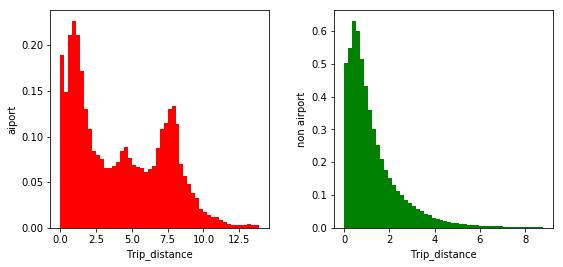

In [26]:
key='Trip_distance'
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
plt.hist(reject_outliers(airport_trips[key],3),bins=50,normed=True, alpha = 1, color = 'r')
plt.xlabel(key)
plt.ylabel('aiport')

ax = fig.add_subplot(1, 2, 2)
plt.hist(reject_outliers(non_air_trips[key],5), bins=50,normed=True, alpha = 1, color = 'g')
plt.xlabel(key)
plt.ylabel('non airport')

Text(0,0.5,'non airport')

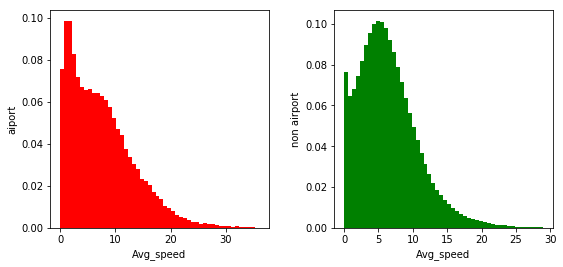

In [27]:
key='Avg_speed'
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
plt.hist(reject_outliers(airport_trips[key],5),bins=50,normed=True, alpha = 1, color = 'r')
plt.xlabel(key)
plt.ylabel('aiport')

ax = fig.add_subplot(1, 2, 2)
plt.hist(reject_outliers(non_air_trips[key],3), bins=50,normed=True, alpha = 1, color = 'g')
plt.xlabel(key)
plt.ylabel('non airport')

Text(0,0.5,'non airport')

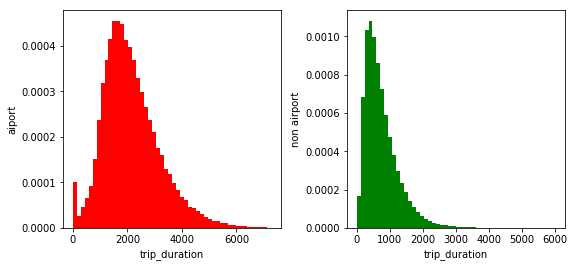

In [28]:
key='trip_duration'
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
plt.hist(reject_outliers(airport_trips[key],5),bins=50,normed=True, alpha = 1, color = 'r')
plt.xlabel(key)
plt.ylabel('aiport')

ax = fig.add_subplot(1, 2, 2)
plt.hist(reject_outliers(non_air_trips[key],1), bins=50,normed=True, alpha = 1, color = 'g')
plt.xlabel(key)
plt.ylabel('non airport')

There are total of 89014 trips orignate or terminate at NYC area airports and 1369630 trips are non-airport trips. <br> 
To find other characteristics of the airport trips, some features are chosen to plot and compared with the non-airport trips. The trip distance, avg_speed and trip time distribution as plotted above show the difference between the airport trips and non-airport trips. For airport trips, there is a larger ratio for longer trips, avg_speed and trip time.

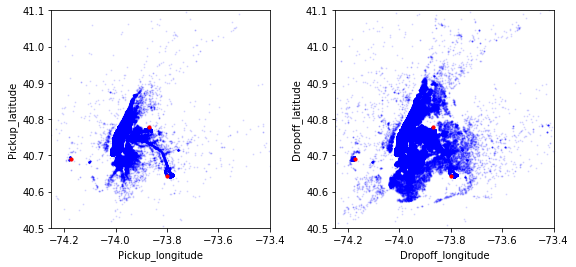

In [29]:
## plot the pickup and dropoff location map to have an over view of all the trip. This is not 
# for answering any question but might be insteresting to see.
#select_columns=['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
long_border = (-74.25, -73.4)
lat_border = (40.5, 41.1)

ax = fig.add_subplot(1, 2, 1)
plt.scatter(clean_data['pickup_longitude'].values, clean_data['pickup_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.scatter([JFK[1],LGA[1],EWR[1]],[JFK[0],LGA[0],EWR[0]],s=10,c='r')
plt.xlim(long_border)
plt.ylim(lat_border)
plt.xlabel('Pickup_longitude')
plt.ylabel('Pickup_latitude')

ax = fig.add_subplot(1, 2, 2)
plt.scatter(clean_data['dropoff_longitude'].values, clean_data['dropoff_latitude'].values,
              color='blue', s=1, alpha=0.1)
plt.scatter([JFK[1],LGA[1],EWR[1]],[JFK[0],LGA[0],EWR[0]],s=10,c='r')
plt.xlim(long_border)
plt.ylim(lat_border)
plt.xlabel('Dropoff_longitude')
plt.ylabel('Dropoff_latitude')
plt.show()

The pickup and dropoff location map gives overview of all the trip. The 3 red dots are the airport locations. Generally, the trips dropoff locations spread more than the pickup locations.


## 5. Feature correlation overview

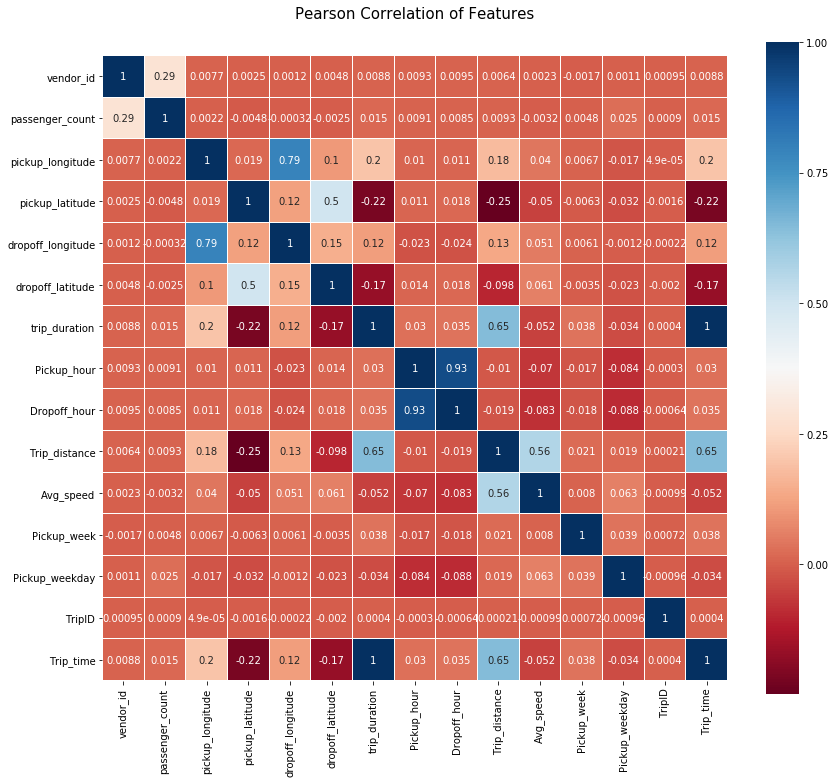

In [30]:
# see feature correlations
# both features and response variable are continuous, use Pearson's correlation to select 
# features
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(clean_data.corr(),linewidths=0.1,vmax=1.0, 
          square=True, cmap=colormap, linecolor='white', annot=True)

The histogram of the total tip percent has a huge peak at 0. The 0 may come from dummy trip records. Since the tip is very correlated with the payment type, cash tips may not recorded. The histogram of nonzero tips is shown on the right. It has peak near 15% which makes sense since most people will give this tip percent.


In [31]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456357 entries, 0 to 1458643
Data columns (total 19 columns):
id                    1456357 non-null object
vendor_id             1456357 non-null int64
pickup_datetime       1456357 non-null datetime64[ns]
dropoff_datetime      1456357 non-null datetime64[ns]
passenger_count       1456357 non-null int64
pickup_longitude      1456357 non-null float64
pickup_latitude       1456357 non-null float64
dropoff_longitude     1456357 non-null float64
dropoff_latitude      1456357 non-null float64
store_and_fwd_flag    1456357 non-null object
trip_duration         1456357 non-null int64
Pickup_hour           1456357 non-null int64
Dropoff_hour          1456357 non-null int64
Trip_distance         1456357 non-null float64
Avg_speed             1456357 non-null float64
Pickup_week           1456357 non-null int64
Pickup_weekday        1456357 non-null int64
TripID                1456357 non-null int64
Trip_time             1456357 non-null float6

## 6. Modeling
### 6.1. Train, cross-validation data set splitting

In [32]:
select_cols=['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude',
             'dropoff_latitude','trip_duration','Pickup_hour','Trip_distance','Avg_speed'
             ,'Pickup_week','Pickup_weekday']
clean_data=clean_data[select_cols].replace([np.inf, -np.inf], np.nan).dropna()

In [33]:
# get train, and test data for modelling
# since total data size is large, only pick a portion of it to speed up modeling process
# uncomment below and skip the next cell for faster running

msk = np.random.rand(len(clean_data)) < 0.2
x_train = clean_data[msk].drop(['trip_duration'], axis=1)
y_train = clean_data[msk]['trip_duration']
rest = clean_data[~msk]

msk = np.random.rand(len(rest)) < 0.1
x_test=rest[msk].drop(['trip_duration'], axis=1)
y_test = rest[msk]["trip_duration"]
len(x_train)
#Tip_NonZero.columns

291306

In [34]:
# get train and test data for modelling
# for simplification, and also since there are other samples for validation, 
# cross-validation data set is not extracted here.
# It will be one more random shuffle process of the total data
#msk = np.random.rand(len(train_data)) < 0.8
#x_train = train_data[msk].drop(['trip_duration'], axis=1)
#y_train = train_data[msk]['trip_duration']
#x_test = train_data[~msk].drop(['trip_duration'], axis=1)
#y_test = train_data[~msk]["trip_duration"]

For continuous variable prediction, the simpliest model is linear regression. Can also try Trees, Random Forsets, Boosting, SVM. I do not go through all of them since the models I have tried already give very good results.

### 6.2. Linear regression

In [35]:
# get all the subset of the feature combinations for model regression
import itertools

def list_of_combs(arr):
    """returns a list of all subsets of a list""" 
    combs = []
    for i in range(0, len(arr)+1):
        listing = [list(x) for x in itertools.combinations(arr, i)]
        combs.extend(listing)
    return combs

cols=list_of_combs(x_train.columns)

In [36]:
# Evaluation of various combinations of Linear regression
# 
from sklearn.linear_model import LinearRegression
accuracy=[]
for index in range(1,100):# change 100 to len(cols) if want to go through all the combinations
    regressor1 = LinearRegression()
    x1_train = x_train[cols[index]]
    x1_test = x_test[cols[index]]
    regressor1.fit(x1_train, y_train)
    accuracy.append(regressor1.score(x1_test, y_test))
print('Linear regression model best score is '+ str(round(max(accuracy),5)))
print('important features are '+str(cols[accuracy.index(max(accuracy))]))

Linear regression model best score is 0.67506
important features are ['passenger_count', 'Pickup_hour', 'Pickup_weekday']


I have run all the combinations, adding more features won't increase the accuracy. The best result is score 0.79162 (this score may vary a little bit for each run). The relevant factors for linear regresssion model are 'passenger_count', 'Pickup_hour', 'Pickup_weekday'.

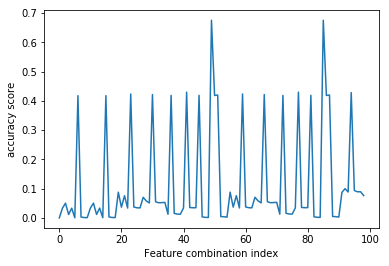

In [37]:
plt.plot(accuracy)
plt.ylabel('accuracy score')
plt.xlabel('Feature combination index')
plt.show()

### 6.3. KNeighbors

In [38]:
# Evaluation of KNeighbors
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(x_train, y_train)
print('KNeighbors model score is '+ str(round(model.score(x_test, y_test),5)))

KNeighbors model score is 0.78255


KNeighbors model score is 0.90908.

### 6.4. Decision Tree

In [39]:
#Evaluation of Bagged Decision Trees model
from sklearn.ensemble import BaggingRegressor
n_estimators=10
model = BaggingRegressor(n_estimators=n_estimators)
model.fit(x_train, y_train)
print('Bagged Decision Trees model score is '+ str(round(model.score(x_test, y_test),5)))

Bagged Decision Trees model score is 0.9954


Bagged Decision Trees model score is 0.99544
### 6.5. RandomForest 

In [40]:
#Evaluation of RandomForest model
from sklearn.ensemble import RandomForestRegressor
n_estimators=10
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(x_train, y_train)
print('RandomForest model score is '+ str(round(model.score(x_test, y_test),5)))

RandomForest model score is 0.99505


RandomForest model score is 0.99536

The linear regression model has score ~0.8. KNeighbors increases to 0.9. Both Bagged Decision Trees model and RandomForest model give very good score ~0.995. Better results may be able to achieve by tuning n_estimators.

## 7. Summary

This progect goes through the base workflow in data analysis. i.e. getting data, data preprocessing, feature selection, data visulzation and building models. The model score is pretty good.